# 1D Bremsstrahlung Synthesis

In [2]:
import numpy as np
from io import StringIO
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numba import njit

with open('./data/Allen-Solar-Atmosphere.txt', 'r', encoding='utf-8') as f:
    text = f.read()
text_fixed = text.replace('–', '-')
data = np.loadtxt(StringIO(text_fixed), skiprows=1)[:, 1:]
# h (km), m (g cm^-2), T (K), V (km s^-1), p_g (dyn cm^-2), p_tot (dyn cm^-2), n_H (cm^-3), n_H1 (cm^-3), n_e (cm^-3)
# shape is (140, 10)
data = data[data[:, 0] >= 0] # filter by positive heights

ht = data[:,0]*1000.*100. # heights
temps = data[:,2] # temperatures
nes = data[:,8]

pg = data[:, 4] # gas pressures
ptot = data[:, 5]  # total pressures
pmag = np.clip(ptot - pg, 0, None)  # magnetic pressures
bb = np.sqrt(8 * np.pi * pmag) # magnetic field along LOS

n_points = ht.size * 10
hts = np.linspace(ht.min(), ht.max(), n_points)
tempInt = interp1d(ht, temps, kind='linear', fill_value='extrapolate')
neInt = interp1d(ht, nes, kind='linear', fill_value='extrapolate')
bbInt = interp1d(ht, bb, kind='linear', fill_value='extrapolate')
temps = tempInt(hts)
nes = neInt(hts)
bb = bbInt(hts)
ht = hts
dht = np.abs(np.diff(ht)) # difference in heights

vs = np.logspace(7, 11, 100) # wavelengths to sample
IV = np.zeros((5, len(vs)))

kb = 1.3807e-16 # erg/K
cc = 299792458 * 100 # speed of light

def tb_to_jansky_1d(tb, v):
    theta_arcsec = 960
    theta_rad = theta_arcsec / 3600 * np.pi / 180
    Omega = np.pi * theta_rad**2
    return 2 * kb * tb * v**2 / cc**2 * Omega * 1e23

for j in range(len(vs)):
    I, V, Tbr, Tbl, taur, taul = 0., 0., 3., 3., 0., 0.
    v = vs[j]
    for i in range(data.shape[0] - 1):
        dl = dht[i]
        Te = temps[i]
        blos = bb[i]
        ne = nes[i]
        f = 2.8e6 * blos/v
        dtau = 0.2 * ne**2/v**2*Te**(-3./2.)*dl
        dtaur = dtau/(1.-f)**2
        dtaul = dtau/(1.+f)**2
        taur = taur + dtaur
        taul = taul + dtaul
        Tbr = Tbr*np.exp(-dtaur)+Te*(1.-np.exp(-dtaur))
        Tbl = Tbl*np.exp(-dtaul)+Te*(1.-np.exp(-dtaul))
    I = (Tbr + Tbl) / 2. # brightness temp units
    V = (Tbr - Tbl) / 2.
    IV[2, j] = I
    IV[3, j] = V
    IV[0, j] = tb_to_jansky_1d(I, v)
    IV[1, j] = tb_to_jansky_1d(V, v)
    IV[4, j] = taur

wav = cc / vs # cm

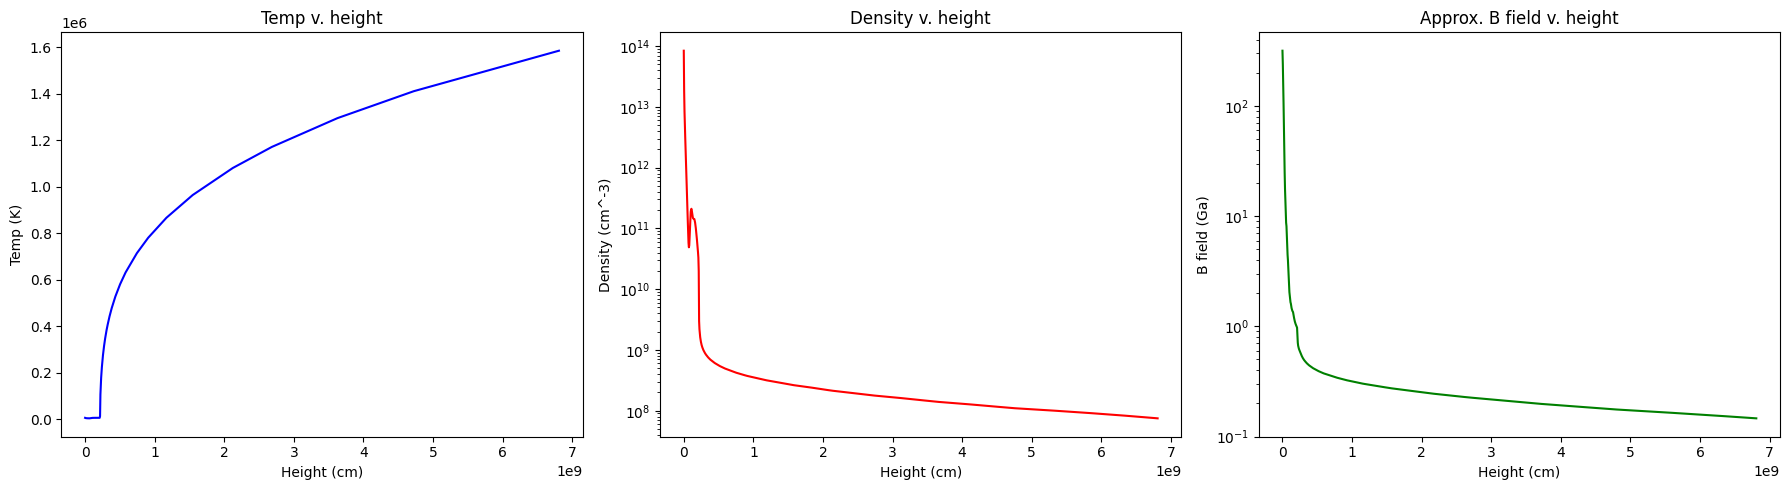

In [3]:
# Plot variance of variables over height
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
axs[0].plot(ht, temps, color='blue')
axs[0].set_xlabel('Height (cm)')
axs[0].set_ylabel('Temp (K)')
axs[0].set_title('Temp v. height')
axs[1].plot(ht, nes, color='red')
axs[1].set_xlabel('Height (cm)')
axs[1].set_ylabel('Density (cm^-3)')
axs[1].set_yscale('log')
axs[1].set_title('Density v. height')
axs[2].set_title('Approx. B field v. height')
axs[2].plot(ht, bb, color='green')
axs[2].set_xlabel('Height (cm)')
axs[2].set_ylabel('B field (Ga)')
axs[2].set_yscale('log')
plt.tight_layout()
plt.show()

Calculated radio intensity:


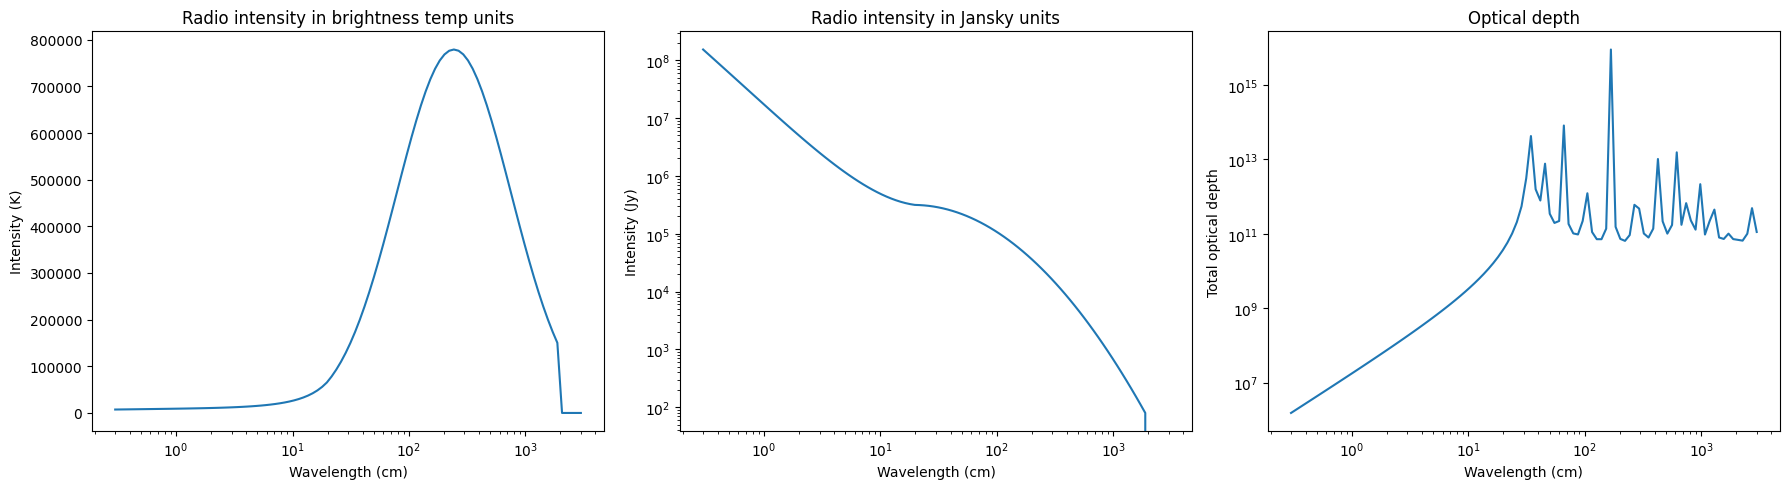

In [ ]:
print('Calculated radio intensity:')
# Plot radio intensity
u = np.log10(wav)
Tb = np.empty_like(wav, dtype=float)
mask1 = (wav >= 0.1) & (wav <= 20)
Tb[mask1] = 10**(3.9609 + 0.1856*u[mask1] + 0.0523*u[mask1]**2 + 0.13415*u[mask1]**3 + 0.0834*u[mask1]**4)
mask2 = (wav > 20) & (wav <= 2000)
Tb[mask2] = 10**(0.7392 + 4.3185*u[mask2] - 0.9049*u[mask2]**2)

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
axs[0].plot(wav, Tb)
axs[0].set_xscale('log')
axs[0].set_xlabel('Wavelength (cm)')
axs[0].set_ylabel('Intensity (K)')
axs[0].set_title('Radio intensity in brightness temp units')
axs[1].set_title('Radio intensity in Jansky units')
axs[1].plot(wav, tb_to_jansky_1d(Tb, vs))
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Wavelength (cm)')
axs[1].set_ylabel('Intensity (Jy)')
axs[2].set_title('Optical depth')
axs[2].plot(wav, IV[4,:])
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('Wavelength (cm)')
axs[2].set_ylabel('Total optical depth')
plt.tight_layout()
plt.show()

Integrated bremsstrahlung intensity (Jy)


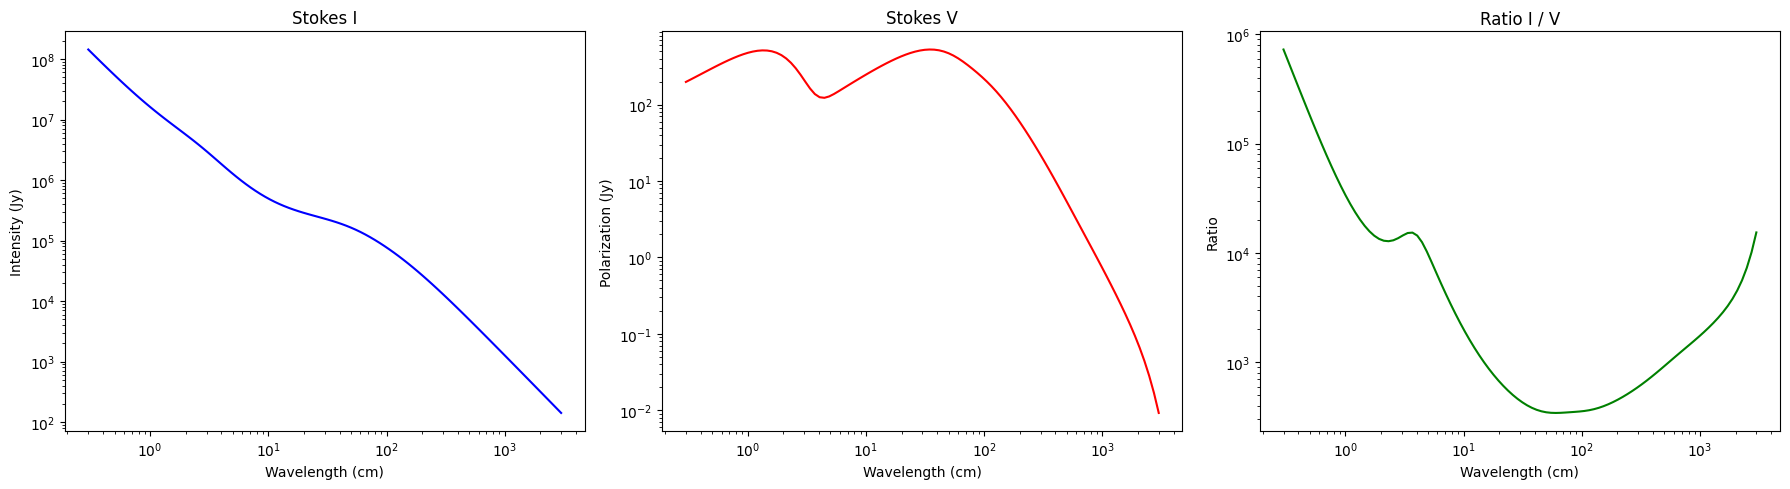

Integrated bremsstrahlung intensity (K)


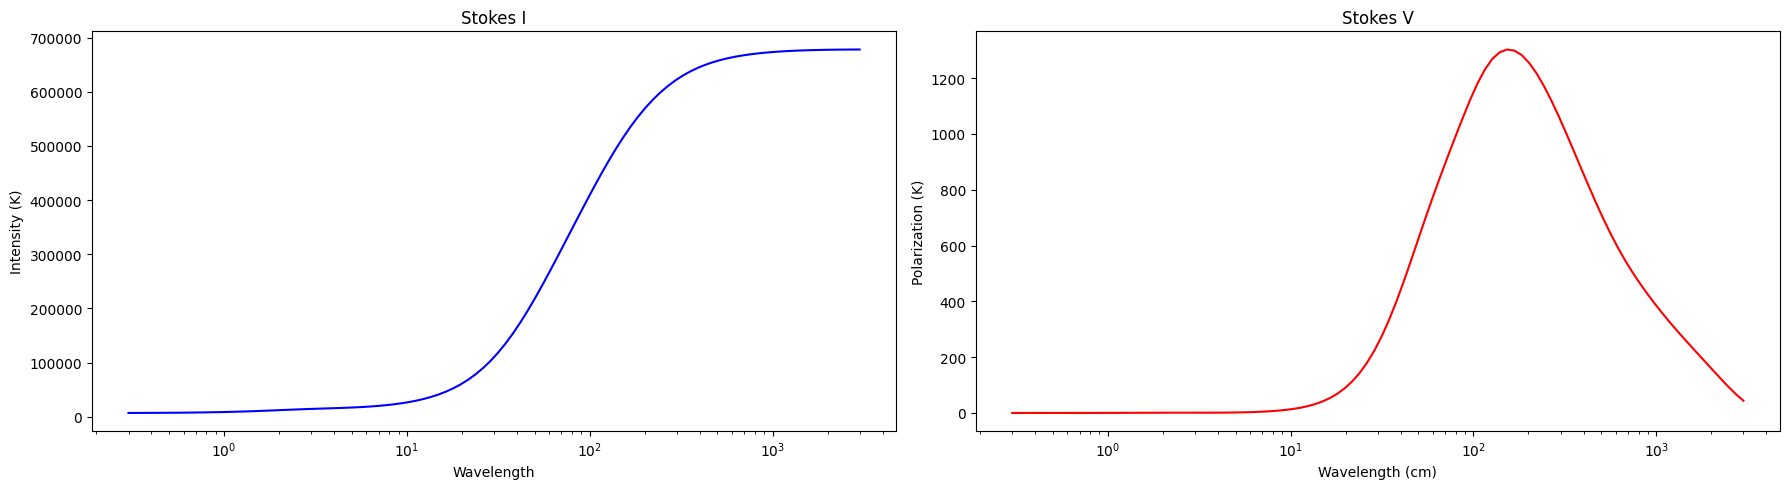

In [5]:
print('Integrated bremsstrahlung intensity (Jy)')
# Jansky units
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
I = IV[0, :]
V = IV[1, :]

# Stokes I
axs[0].plot(wav, I, color='blue')
axs[0].set_title('Stokes I')
axs[0].set_xlabel('Wavelength (cm)')
axs[0].set_ylabel('Intensity (Jy)')
# axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

# Stokes V
axs[1].plot(wav, V, color='red')
axs[1].set_title('Stokes V')
axs[1].set_xlabel('Wavelength (cm)')
axs[1].set_ylabel('Polarization (Jy)')
# axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# Stokes I/V
axs[2].plot(wav, I/V, color='green')
axs[2].set_title('Ratio I / V')
axs[2].set_xlabel('Wavelength (cm)')
axs[2].set_ylabel('Ratio')
# axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_yscale('log')

plt.tight_layout()
plt.show()

print('Integrated bremsstrahlung intensity (K)')
# Brightness temperature units
I = IV[2, :]
V = IV[3, :]
fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

# Stokes I
axs[0].plot(wav, I, color='blue')
axs[0].set_title('Stokes I')
axs[0].set_xlabel('Wavelength')
axs[0].set_ylabel('Intensity (K)')
# axs[0].set_yscale('log')
axs[0].set_xscale('log')

# Stokes V
axs[1].plot(wav, V, color='red')
axs[1].set_title('Stokes V')
axs[1].set_xlabel('Wavelength (cm)')
axs[1].set_ylabel('Polarization (K)')
# axs[1].set_yscale('log')
axs[1].set_xscale('log')

plt.tight_layout()
plt.show()

In [6]:
vs = np.logspace(4, 11, 100)

@njit(parallel=True)
def optical_integrate(vs, dht, temps, bb, nes):
    taus_vh = np.zeros((len(vs), len(dht) + 1))
    for j, v in enumerate(vs):
        for h in range(len(dht)):
            taur = 0.0
            for i in range(h):
                dl = dht[i]
                Te = temps[i]
                blos = bb[i]
                ne = nes[i]
                f = 2.8e6 * blos / v
                dtau = 0.2 * ne**2 / v**2 * Te**(-1.5) * dl
                dtaur = dtau / (1. - f)**2
                taur += dtaur
            taus_vh[j, h] = taur
    return taus_vh

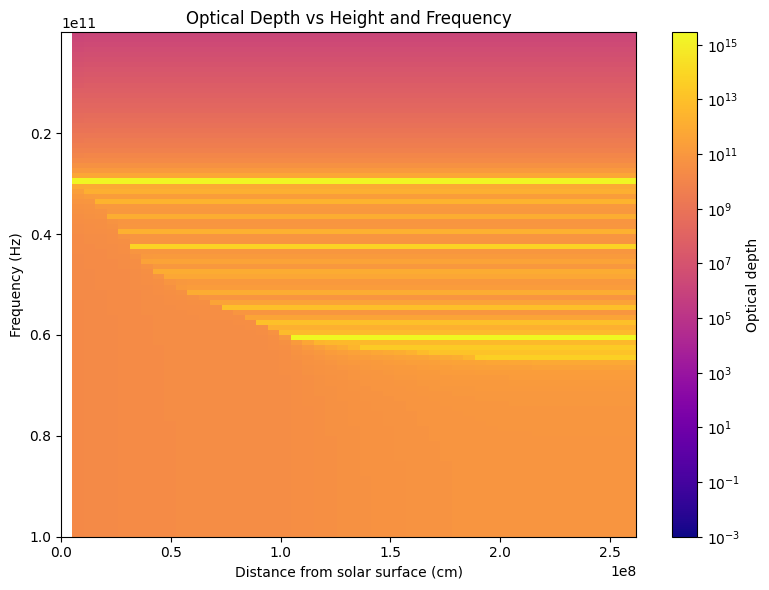

In [7]:
taus_vh = optical_integrate(vs, dht, temps, bb, nes)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    taus_vh[:,:50],
    aspect='auto',
    origin='lower',
    extent=[ht[0], ht[50], vs[-1], vs[0]],  # x: height, y: freq in GHz
    cmap='plasma',
    norm=LogNorm(vmin=1e-3, vmax=np.nanmax(taus_vh))
)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Optical depth')
ax.set_xlabel('Distance from solar surface (cm)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('Optical Depth vs Height and Frequency')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Optical depth vs. height')

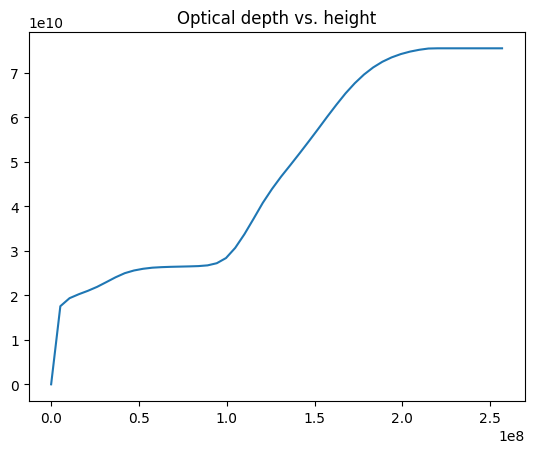

In [ ]:
plt.plot(ht[:50], taus_vh[0][:50])
plt.title('Optical depth vs. height')